In [196]:
#importuje wszytskie potrzebne biblioteki w tym biblioteke kwant
import kwant
import numpy as np
import types
import matplotlib.pyplot as plt
      
    
#Obliczenia prowadze sa w jednostkach atomowych e=h=me=1. Tutaj definiuje wspolczynniki konwersji.
def eV2au(energy): #eV -> j.a
    return energy*0.03674932587122423
def nm2au(length): #nm -> j.a
    return length*18.89726133921252
def T2au(length):  #T -> j.a
    return length*4.254382E-6


In [197]:

t = eV2au(3)
sin_30 = np.sin(30*np.pi/180)
cos_30 = np.cos(30*np.pi/180)

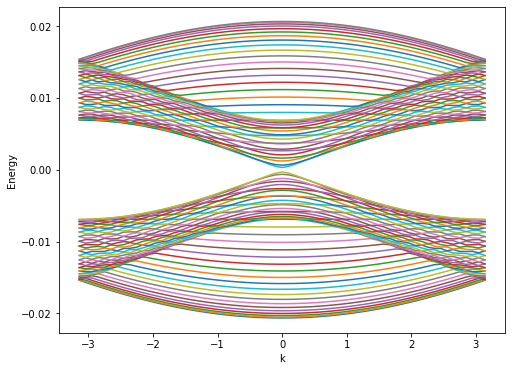

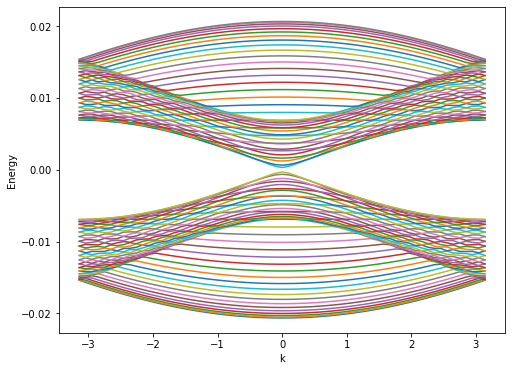

In [198]:
def make_system(x_min = -100, x_max = 100, y_min = -39.9, y_max = 39.9, w = 46, sf = 16):
    y_min = nm2au(y_min)
    y_max = nm2au(y_max)
    x_min = nm2au(x_min)
    x_max = nm2au(x_max)
    t0 = t/sf
    t_si = 3/sf  #Potrzebujemy tych wartości w SI to obliczenia n(x)
    a_cc_si = 0.25e-9*sf/np.sqrt(3)
    a0 = nm2au (0.25) * sf
    a_cc = a0/np.sqrt(3)
    
    C_bg = 7.2402392330e14 
    C_tg = 12.8*C_bg
    w = nm2au(w)


    graphene = kwant.lattice.general([(0 , a0 ) , ( cos_30 *a0 , sin_30 * a0 )],
                                         [(0 , 0) , ( a_cc , 0) ], norbs =1)

    lat_A, lat_B = graphene.sublattices

    def rect(pos):
        x, y = pos
        if x_min<=x<=x_max and y_min<=y<=y_max:
            return True
        else:
            return False

    def lead_shape(pos):
        x, y = pos
        return (y_min <= y <= y_max)
    

    def calc_n_x(x, V_tg, V_bg):
        return (C_tg*V_tg)/(1 + np.abs(x/w)**(2.5)) + V_bg*C_bg

    
    def potential(site, V_tg, V_bg):
        x, y = site.pos
        n_x = calc_n_x(x, V_tg, V_bg)
        return eV2au(-np.sign(n_x) * (3*t_si*a_cc_si)/2 * np.sqrt(np.pi * np.abs(n_x)))
    
    def lead_onsite_left(site, V_tg, V_bg):
        nL = calc_n_x(x_min, V_tg, V_bg)
        return eV2au(-np.sign(nL) * (3*t_si*a_cc_si)/2 * np.sqrt(np.pi * np.abs(nL)))

    def lead_onsite_right(site, V_tg, V_bg):
        nR = calc_n_x(x_max, V_tg, V_bg)
        return eV2au(-np.sign(nR) * (3*t_si*a_cc_si)/2 * np.sqrt(np.pi * np.abs(nR)))
    
#     V_tg_table = np.linspace(-20, 20, 21)
#     for V_tg in V_tg_table:
#         x_table = np.linspace(x_min, x_max, 200)
#         V_table = np.zeros(200)
#         for i, x in enumerate(x_table):
#             V_table[i] = eV2au(-np.sign(calc_n_x(x)) * (3*t_si*a_cc_si)/(2) * np.sqrt(np.pi * np.abs(calc_n_x(x))))
#         plt.plot(x_table, V_table)
#     plt.show()

    def nn_hopping(site1, site2, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        flux = -T2au(B) * (y1+y2) * (x2-x1) / 2
        return -(t0) * np.exp(1j*flux)

    sys = kwant.Builder()
    sys[graphene.shape(rect, (0, 0))] = potential
    sys[graphene.neighbors()] = nn_hopping

    syml = kwant.TranslationalSymmetry([-np.sqrt(3)*a0, 0])
    symr = kwant.TranslationalSymmetry([ np.sqrt(3)*a0, 0])

    leadl = kwant.Builder(syml)
    leadl[graphene.shape(lead_shape, (0, 0))] = lead_onsite_left
    leadl[graphene.neighbors()] = nn_hopping

    leadr = kwant.Builder(symr)
    leadr[graphene.shape(lead_shape, (0, 0))] = lead_onsite_right
    leadr[graphene.neighbors()] = nn_hopping

    sys.attach_lead(leadl)
    sys.attach_lead(leadr)

    return sys.finalized()

sysf = make_system()
kwant.plotter.bands(
    sysf.leads[0],
    show=True,
    fig_size=(8, 6),
    params=dict(V_tg=0.0, V_bg=0.0, B=0.0)
)

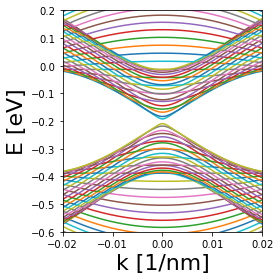

In [199]:
def dispersion(nr_lead, k_max, nk, V_tg, V_bg, B):
    sys = make_system()
    momenta = np.linspace(-k_max*dx, k_max*dx, nk)
    bands = kwant.physics.Bands(sys.leads[nr_lead], params=dict(V_tg=V_tg, V_bg=V_bg, B=B))
    energies = [bands(k) for k in momenta]
    return (momenta/dx), energies


sf = 16
a0 = nm2au(0.25)*sf
dx = np.sqrt(3)*a0

V_tg = -5.0
V_bg = 50
B = 0.0

momenta, energies = dispersion(0, np.pi/dx, 400, V_tg=V_tg, V_bg=V_bg, B=B)

plt.figure(figsize=(4, 4))
plt.plot(momenta, np.asarray(energies)/eV2au(1.0))
plt.xlabel("k [1/nm]", fontsize=22)
plt.ylabel("E [eV]", fontsize=22)
plt.ylim(-0.6, 0.2)
plt.xlim(-0.02, 0.02)
plt.tight_layout()
plt.show()


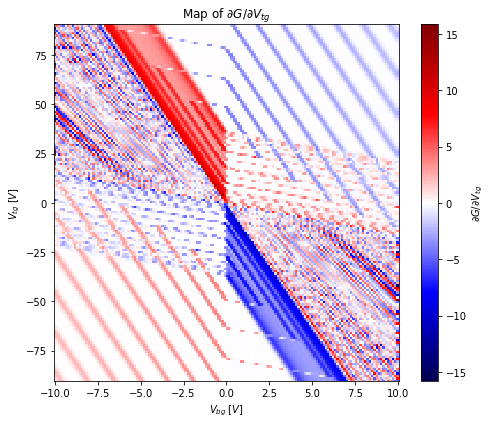

In [201]:
from joblib import Parallel, delayed

sysf = make_system()

E = 0.0
B = 0.0

V_tg_min = -10
V_tg_max = 10
N_tg = 150
V_tg_table = np.linspace(V_tg_min, V_tg_max, N_tg)

V_bg_min = -90
V_bg_max = 90
N_bg = 150
V_bg_table = np.linspace(V_bg_min, V_bg_max, N_bg)

def G_point(i, j):
    V_tg = V_tg_table[i]
    V_bg = V_bg_table[j]
    smatrix = kwant.smatrix(sysf, E, params=dict(V_tg=V_tg, V_bg=V_bg, B=B))
    return i, j, smatrix.transmission(1, 0)

results = Parallel(n_jobs=-1, backend="loky")(
    delayed(G_point)(i, j) for i in range(N_tg) for j in range(N_bg)
)

G = np.zeros((N_tg, N_bg))
for i, j, val in results:
    G[i, j] = val

dVtg = V_tg_table[1] - V_tg_table[0]
dG_dVtg = np.gradient(G, dVtg, axis=0)

VBG, VTG = np.meshgrid(V_bg_table, V_tg_table)

vmax = np.max(np.abs(dG_dVtg))

plt.figure(figsize=(7, 6))
plt.pcolormesh(VTG, VBG, dG_dVtg, shading="auto", vmin=-vmax, vmax=vmax, cmap="seismic")
plt.colorbar(label=r"$\partial G/\partial V_{tg}$")
plt.xlabel(r"$V_{bg}\;[V]$")
plt.ylabel(r"$V_{tg}\;[V]$")
plt.title(r"Map of $\partial G/\partial V_{tg}$")
plt.tight_layout()
plt.savefig("dGdVtg_map.png", dpi=250)
plt.show()


In [167]:
V_tg_min = -10
V_tg_max = -3.7
V_tg_table = np.linspace(V_tg_min, V_tg_max, 100)
E = 0

B_table = np.arange(0, 3.0, 0.6)

plt.figure(figsize=(8, 6))

for B in B_table:
    cond_table = [] 
    print(B_table)

    for V_tg in V_tg_table:
        sys = make_system(V_tg=V_tg, B=B)
        smatrix = kwant.smatrix(sys, E)
        cond_table.append(smatrix.transmission(1, 0))
        print(V_tg)

    plt.plot(V_tg_table, cond_table, label=f"B = {B:.3f}")

plt.xlabel(r"$V_{tg} [V]$")
plt.ylabel(r"$G \; [2e^2/h]$")
plt.title("Conductance vs V_tg for different B")
plt.legend()
plt.tight_layout()
plt.savefig("conductance.png", dpi=200)
plt.show()


[0.  0.6 1.2 1.8 2.4]


KeyboardInterrupt: 

<Figure size 576x432 with 0 Axes>